# Philips Supplier Sustainability Analytics

This notebook builds predictive models for supplier sustainability scores using two feature sets:
1. **GI-only (General Information):** Observable supplier characteristics (activities, facilities, workforce)
2. **GI+SAQ:** GI data plus Self-Assessment Questionnaire responses

**Assignment Requirements:**
- Two-stage results comparison (GI-only vs GI+SAQ)
- Feature importance with business interpretation
- Risk segmentation framework (5 tiers)
- Fairness analysis across regions
- Visualizations and recommendations

## 1. Import Libraries

In [25]:
# Cell 1: Import all required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, roc_auc_score, precision_recall_fscore_support
)
from sklearn.utils import check_random_state

# SHAP for interpretability
import shap

# Ensure output directory exists
Path("analysis_outputs").mkdir(exist_ok=True)

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load Data

In [26]:
# Cell 2: Load the dataset and display basic information

DATA_PATH = Path("data/SSP_Data.xlsx")

# Load main data sheet
raw_df = pd.read_excel(DATA_PATH, sheet_name="Data")
raw_df.set_index("Index", inplace=True)

# Load column explanations for interpreting Q-codes
column_meta = pd.read_excel(DATA_PATH, sheet_name="Column Explanation")
column_meta["Column header"] = column_meta["Column header"].astype(str)
COLUMN_TOPIC_LOOKUP = column_meta.set_index("Column header")["Topic"].fillna("-").to_dict()
COLUMN_CHAPTER_LOOKUP = column_meta.set_index("Column header")["Chapter"].fillna("-").to_dict()

print(f"Dataset shape: {raw_df.shape}")
print(f"Number of unique suppliers: {raw_df['ID'].nunique()}")
print(f"Assessment years: {raw_df['Assessment Year'].min()} - {raw_df['Assessment Year'].max()}")
raw_df.head()

Dataset shape: (1262, 494)
Number of unique suppliers: 463
Assessment years: 2016 - 2025


,ID,Sequence,Assessment Year,Assessment type,Country,Val_Score,Val_Environment,Val_Health and Safety,Val_Business Ethics,Val_Labor and Human Rights,...,Q953_3,Q953_4,Q953_5,Q1443,Q1446,Q1449,Q1450,Q954,Q956,Q1452
Index,,,,,,,,,,,,,,,,,,,,,
256-1,256,1,2017,DV - Desktop Validation,China,0.67175,0.7110,0.7614,0.694,0.5206,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
256-2,256,2,2018,SA - Site Assessment,China,0.73240,0.8800,0.7210,0.721,0.6076,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
256-3,256,3,2019,SA - Site Assessment,China,0.71215,0.8250,0.6536,0.721,0.6490,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
256-4,256,4,2020,DV - Desktop Validation,China,0.76200,0.8550,0.7140,0.800,0.6790,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
745-1,745,1,2019,SA - Site Assessment,Indonesia,0.56180,0.8336,0.4546,0.355,0.6040,...,1.0,0.0,0.0,0.0,NaN,NaN,0.0,1.0,1.0,1.0


## 3. Define Constants and Feature Sets

In [27]:
# Cell 3: Define constants and identify feature sets

# Key columns
ID_COLUMN = "ID"
TARGET_COLUMN = "Val_Score"
BIC_THRESHOLD = 0.75  # Best-in-Class threshold per Philips guidance
MAX_MISSING_RATE = 0.95  # Drop features with >95% missing values

# GI Features: Activities, Facilities, Workforce (31 features total)
GI_RANGE_START = "Activities - Raw material extraction"
GI_RANGE_END = "Number of workers - Indirect employed"
gi_block = list(raw_df.loc[:, GI_RANGE_START:GI_RANGE_END].columns)
GI_CATEGORICAL = ["Country", "Assessment type", "Assessment Year"]
GI_FEATURES = GI_CATEGORICAL + gi_block

# SAQ Features: All Q-code columns (questionnaire responses)
SAQ_FEATURES = [col for col in raw_df.columns if col.startswith("Q")]

print(f"GI feature count: {len(GI_FEATURES)}")
print(f"SAQ feature count: {len(SAQ_FEATURES)}")
print(f"\nGI Features include:")
print(f"  - Categorical: {GI_CATEGORICAL}")
print(f"  - Activities/Facilities/Workforce: {len(gi_block)} features")

# Store feature sets for easy iteration
FEATURE_SETS = {
    "gi_only": {
        "features": GI_FEATURES,
        "description": "General Information only (observable characteristics)"
    },
    "gi_plus_saq": {
        "features": GI_FEATURES + SAQ_FEATURES,
        "description": "GI + Self-Assessment Questionnaire responses"
    }
}

GI feature count: 31
SAQ feature count: 450

GI Features include:
  - Categorical: ['Country', 'Assessment type', 'Assessment Year']
  - Activities/Facilities/Workforce: 28 features


## 4. Data Quality Audit

Before modeling, we check:
1. Missing value rates
2. Target variable distribution
3. Geographic distribution

In [28]:
# Cell 4: Analyze missing values

def compute_missing_rates(df, columns, top_n=10):
    """Return sorted table of missing value percentages."""
    rates = df[columns].isna().mean().sort_values(ascending=False).head(top_n)
    return rates.to_frame(name="missing_rate")

# Show top missing features for each set
print("=== Top 10 Missing Features (GI-only) ===")
display(compute_missing_rates(raw_df, GI_FEATURES))

print("\n=== Top 10 Missing Features (GI+SAQ) ===")
display(compute_missing_rates(raw_df, GI_FEATURES + SAQ_FEATURES))

=== Top 10 Missing Features (GI-only) ===


,missing_rate
Activities - Testing and measurement,0.858954
Number of workers - Indirect employed,0.858162
Activities - Surface treatment / plating,0.858162
Activities - Silkscreen / pad printing,0.858162
Activities - Packaging (cardboard / colorbox / pulp tray / label / blister),0.858162
Facilities - Kitchen,0.005547
Facilities - Canteen,0.005547
Facilities - Dormitory on site or employer provided accommodation close to the site,0.005547
Facilities - Power generation,0.004754
Facilities - Hospital / infirmary,0.003962



=== Top 10 Missing Features (GI+SAQ) ===


,missing_rate
Q1630,0.992868
Q1629,0.992868
Q1638,0.983360
Q1632,0.969889
Q951_10,0.905705
Q946_10,0.899366
Q293_10,0.891442
Q304_10,0.891442
Q1647,0.887480
Q301_10,0.886688


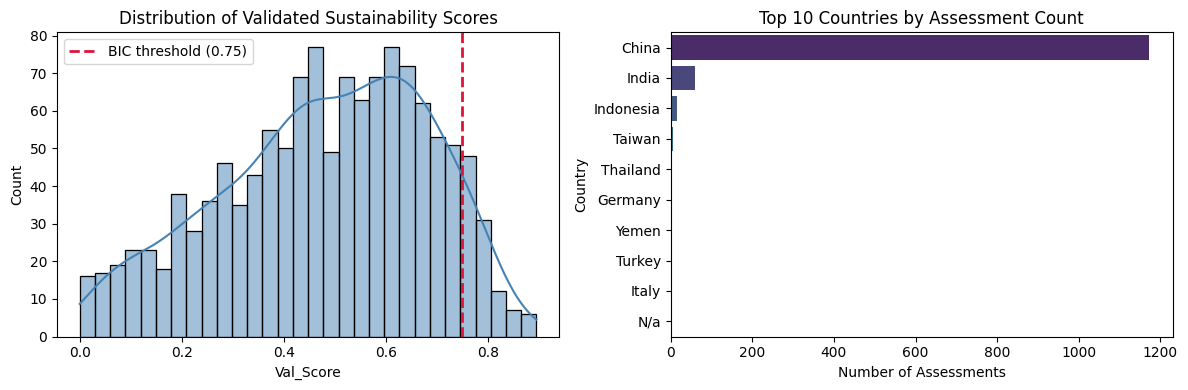


Best-in-Class suppliers: 97 / 1262 (7.7%)


In [29]:
# Cell 5: Visualize target distribution

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: Histogram of Val_Score
ax1 = axes[0]
sns.histplot(raw_df[TARGET_COLUMN].dropna(), bins=30, kde=True, color="steelblue", ax=ax1)
ax1.axvline(BIC_THRESHOLD, color="crimson", linestyle="--", linewidth=2, label=f"BIC threshold ({BIC_THRESHOLD})")
ax1.set_title("Distribution of Validated Sustainability Scores")
ax1.set_xlabel("Val_Score")
ax1.set_ylabel("Count")
ax1.legend()

# Right: Country distribution
ax2 = axes[1]
country_counts = raw_df["Country"].value_counts().head(10)
sns.barplot(x=country_counts.values, y=country_counts.index, palette="viridis", ax=ax2)
ax2.set_title("Top 10 Countries by Assessment Count")
ax2.set_xlabel("Number of Assessments")

plt.tight_layout()
plt.show()

# Print BIC statistics
bic_count = (raw_df[TARGET_COLUMN] >= BIC_THRESHOLD).sum()
total_count = raw_df[TARGET_COLUMN].notna().sum()
print(f"\nBest-in-Class suppliers: {bic_count} / {total_count} ({100*bic_count/total_count:.1f}%)")

## 5. Train/Test Split (Region-Stratified)

**Critical:** We split by Supplier ID (not randomly) to prevent data leakage.
Additionally, we stratify by region to ensure both China and Rest-of-World are represented in the test set for fairness analysis.

In [30]:
# Cell 6: Prepare data and create region-stratified split

# Remove rows without validated scores or country
model_df = raw_df.dropna(subset=[TARGET_COLUMN, "Country"]).copy()

# Create binary BIC label
model_df["is_bic"] = (model_df[TARGET_COLUMN] >= BIC_THRESHOLD).astype(int)

# Normalize country names and create region groups
model_df["Country"] = model_df["Country"].astype(str).str.strip().str.title()
model_df["region_group"] = np.where(model_df["Country"].eq("China"), "China", "Rest of World")

print(f"Assessments after cleaning: {len(model_df)}")
print(f"Unique suppliers: {model_df[ID_COLUMN].nunique()}")
print(f"\nRegion distribution:")
print(model_df["region_group"].value_counts())

Assessments after cleaning: 1262
Unique suppliers: 463

Region distribution:
region_group
China            1172
Rest of World      90
Name: count, dtype: int64


In [31]:
# Cell 7: Stratified group split function

def stratified_group_split(df, group_col, strata_col, test_size=0.2, random_state=42):
    """
    Split data by groups (suppliers), stratified by strata (region).
    Ensures both regions are represented in train and test sets.
    """
    rng = check_random_state(random_state)
    suppliers = df[[group_col, strata_col]].drop_duplicates()
    test_ids = []
    
    for region, group in suppliers.groupby(strata_col):
        ids = group[group_col].unique()
        n_test = max(1, int(round(test_size * len(ids))))
        chosen = rng.choice(ids, size=n_test, replace=False)
        test_ids.extend(chosen)
    
    test_mask = df[group_col].isin(test_ids)
    train_idx = (~test_mask).to_numpy().nonzero()[0]
    test_idx = test_mask.to_numpy().nonzero()[0]
    return train_idx, test_idx

# Perform the split
train_idx, test_idx = stratified_group_split(
    model_df, group_col=ID_COLUMN, strata_col="region_group", test_size=0.2, random_state=42
)
train_df = model_df.iloc[train_idx].copy()
test_df = model_df.iloc[test_idx].copy()

# Verify split quality
print("=== Train/Test Split Summary ===")
print(f"Training: {len(train_df)} assessments from {train_df[ID_COLUMN].nunique()} suppliers")
print(f"Testing:  {len(test_df)} assessments from {test_df[ID_COLUMN].nunique()} suppliers")
print(f"\nRegion distribution in TEST set:")
print(test_df.groupby("region_group")[ID_COLUMN].nunique())

=== Train/Test Split Summary ===
Training: 1021 assessments from 370 suppliers
Testing:  241 assessments from 93 suppliers

Region distribution in TEST set:
region_group
China            81
Rest of World    12
Name: ID, dtype: int64


## 6. Feature Engineering Pipelines

In [32]:
# Cell 8: Build preprocessing pipelines

def build_preprocessor(df, feature_list):
    """Create preprocessing pipeline for given features."""
    # Identify categorical vs numeric features
    categorical = [col for col in feature_list if df[col].dtype == "object"]
    numeric = [col for col in feature_list if col not in categorical]
    
    # Numeric: impute median + add missing indicators + scale
    numeric_pipeline = Pipeline([
        ("impute", SimpleImputer(strategy="median", add_indicator=True)),
        ("scale", StandardScaler()),
    ])
    
    # Categorical: impute mode + one-hot encode
    categorical_pipeline = Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encode", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("numeric", numeric_pipeline, numeric),
            ("categorical", categorical_pipeline, categorical),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )
    
    return preprocessor, numeric, categorical

# Build feature bundles for both feature sets
feature_bundles = {}

for key, meta in FEATURE_SETS.items():
    feature_list = meta["features"]
    
    # Filter out features with excessive missingness
    missing_rates = train_df[feature_list].isna().mean()
    filtered_features = missing_rates[missing_rates <= MAX_MISSING_RATE].index.tolist()
    dropped = set(feature_list) - set(filtered_features)
    
    if dropped:
        print(f"{key}: Dropped {len(dropped)} features with >{MAX_MISSING_RATE:.0%} missing")
    
    preprocessor, numeric_cols, categorical_cols = build_preprocessor(train_df, filtered_features)
    
    feature_bundles[key] = {
        "preprocessor": preprocessor,
        "filtered_features": filtered_features,
        "X_train": train_df[filtered_features],
        "X_test": test_df[filtered_features],
        "y_train_reg": train_df[TARGET_COLUMN],
        "y_test_reg": test_df[TARGET_COLUMN],
        "y_train_clf": train_df["is_bic"],
        "y_test_clf": test_df["is_bic"],
    }

print("\n=== Feature Bundles Ready ===")
for name, bundle in feature_bundles.items():
    print(f"  {name}: {len(bundle['filtered_features'])} features")

gi_plus_saq: Dropped 4 features with >95% missing

=== Feature Bundles Ready ===
  gi_only: 31 features
  gi_plus_saq: 477 features


## 7. Baseline Metrics

We establish baselines using naive predictions:
- **Regression:** Predict mean score for all suppliers
- **Classification:** Predict majority class (non-BIC) for all suppliers

In [33]:
# Cell 9: Calculate baseline performance

baseline_results = {}

for key, bundle in feature_bundles.items():
    y_train_reg = bundle["y_train_reg"]
    y_test_reg = bundle["y_test_reg"]
    y_train_clf = bundle["y_train_clf"]
    y_test_clf = bundle["y_test_clf"]
    
    # Regression baseline: predict mean
    mean_pred = np.full_like(y_test_reg, fill_value=y_train_reg.mean(), dtype=float)
    rmse_baseline = np.sqrt(mean_squared_error(y_test_reg, mean_pred))
    
    # Classification baseline: predict majority class
    majority = int(y_train_clf.mode()[0])
    majority_pred = np.full_like(y_test_clf, fill_value=majority)
    acc_baseline = accuracy_score(y_test_clf, majority_pred)
    
    baseline_results[key] = {
        "rmse": rmse_baseline,
        "accuracy": acc_baseline,
        "mean_target": y_train_reg.mean(),
        "majority_label": majority,
    }

baseline_df = pd.DataFrame(baseline_results).T
print("=== Baseline Performance ===")
display(baseline_df)
print(f"\nNote: High accuracy baseline ({baseline_df['accuracy'].iloc[0]:.1%}) reflects class imbalance.")

=== Baseline Performance ===


,rmse,accuracy,mean_target,majority_label
gi_only,0.208862,0.912863,0.476236,0.0
gi_plus_saq,0.208862,0.912863,0.476236,0.0



Note: High accuracy baseline (91.3%) reflects class imbalance.


## 8. Model Training & Evaluation

We train multiple models for both feature sets:
- **Regression:** Ridge, Random Forest (to predict Val_Score)
- **Classification:** Logistic Regression, Random Forest (to predict BIC status)

In [34]:
# Cell 10: Train all models

model_results = []
model_registry = {}

for feature_key, bundle in feature_bundles.items():
    preprocessor = bundle["preprocessor"]
    
    # Define models
    regressors = {
        "ridge": Ridge(alpha=1.0),
        "random_forest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    }
    classifiers = {
        "logistic_regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
        "random_forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    }
    
    # Train regressors
    for model_name, model in regressors.items():
        pipeline = Pipeline([("prep", preprocessor), ("model", model)])
        pipeline.fit(bundle["X_train"], bundle["y_train_reg"])
        preds = pipeline.predict(bundle["X_test"])
        
        rmse = np.sqrt(mean_squared_error(bundle["y_test_reg"], preds))
        mae = mean_absolute_error(bundle["y_test_reg"], preds)
        r2 = r2_score(bundle["y_test_reg"], preds)
        
        model_key = f"{feature_key}__regression__{model_name}"
        model_registry[model_key] = pipeline
        
        model_results.append({
            "feature_set": feature_key,
            "task": "regression",
            "model": model_name,
            "rmse": rmse,
            "mae": mae,
            "r2": r2,
        })
    
    # Train classifiers
    for model_name, model in classifiers.items():
        pipeline = Pipeline([("prep", preprocessor), ("model", model)])
        pipeline.fit(bundle["X_train"], bundle["y_train_clf"])
        preds = pipeline.predict(bundle["X_test"])
        proba = pipeline.predict_proba(bundle["X_test"])[:, 1]
        
        acc = accuracy_score(bundle["y_test_clf"], preds)
        auc = roc_auc_score(bundle["y_test_clf"], proba)
        prec, rec, f1, _ = precision_recall_fscore_support(bundle["y_test_clf"], preds, average="binary")
        
        model_key = f"{feature_key}__classification__{model_name}"
        model_registry[model_key] = pipeline
        
        model_results.append({
            "feature_set": feature_key,
            "task": "classification",
            "model": model_name,
            "accuracy": acc,
            "roc_auc": auc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
        })

model_results_df = pd.DataFrame(model_results)
print(f"Trained {len(model_registry)} models successfully!")

Trained 8 models successfully!


## 9. Results Comparison: GI-only vs GI+SAQ

This is the key comparison showing the value of SAQ data.

In [35]:
# Cell 11: Create comparison tables

# Regression results
regression_df = model_results_df[model_results_df["task"] == "regression"].copy()
regression_pivot = regression_df.pivot(index="model", columns="feature_set", values=["rmse", "r2"])
print("=== Regression Results ===")
display(regression_pivot)

# Classification results  
classification_df = model_results_df[model_results_df["task"] == "classification"].copy()
classification_pivot = classification_df.pivot(index="model", columns="feature_set", values=["roc_auc", "accuracy"])
print("\n=== Classification Results ===")
display(classification_pivot)

=== Regression Results ===


rmse                    r2            
feature_set     gi_only gi_plus_saq   gi_only gi_plus_saq
model                                                    
random_forest  0.176970    0.153521  0.277170    0.456031
ridge          0.188593    0.534810  0.179102   -5.601405


=== Classification Results ===


roc_auc              accuracy            
feature_set           gi_only gi_plus_saq   gi_only gi_plus_saq
model                                                          
logistic_regression  0.672294    0.837229  0.713693    0.875519
random_forest        0.839177    0.874242  0.921162    0.925311

In [36]:
# Cell 12: Summary comparison table (Random Forest only - best model)

# Extract Random Forest results for the comparison table
rf_gi = model_results_df[(model_results_df["model"] == "random_forest") & 
                          (model_results_df["feature_set"] == "gi_only")]
rf_saq = model_results_df[(model_results_df["model"] == "random_forest") & 
                           (model_results_df["feature_set"] == "gi_plus_saq")]

rf_gi_reg = rf_gi[rf_gi["task"] == "regression"].iloc[0]
rf_gi_clf = rf_gi[rf_gi["task"] == "classification"].iloc[0]
rf_saq_reg = rf_saq[rf_saq["task"] == "regression"].iloc[0]
rf_saq_clf = rf_saq[rf_saq["task"] == "classification"].iloc[0]

comparison_data = {
    "Metric": ["RMSE (lower is better)", "R² (higher is better)", "AUC (higher is better)", "Accuracy"],
    "GI-Only": [
        f"{rf_gi_reg['rmse']:.3f}",
        f"{rf_gi_reg['r2']:.3f}",
        f"{rf_gi_clf['roc_auc']:.3f}",
        f"{rf_gi_clf['accuracy']:.1%}",
    ],
    "GI+SAQ": [
        f"{rf_saq_reg['rmse']:.3f}",
        f"{rf_saq_reg['r2']:.3f}",
        f"{rf_saq_clf['roc_auc']:.3f}",
        f"{rf_saq_clf['accuracy']:.1%}",
    ],
    "Improvement": [
        f"{(rf_gi_reg['rmse'] - rf_saq_reg['rmse'])/rf_gi_reg['rmse']*100:+.0f}%",
        f"{(rf_saq_reg['r2'] - rf_gi_reg['r2'])/max(rf_gi_reg['r2'], 0.001)*100:+.0f}%",
        f"{(rf_saq_clf['roc_auc'] - rf_gi_clf['roc_auc'])*100:+.1f} pts",
        f"{(rf_saq_clf['accuracy'] - rf_gi_clf['accuracy'])*100:+.1f} pts",
    ]
}

comparison_table = pd.DataFrame(comparison_data)
print("\n" + "="*60)
print("     KEY RESULTS: GI-Only vs GI+SAQ (Random Forest)")
print("="*60)
display(comparison_table)
print("\n→ Adding SAQ data significantly improves prediction performance!")


     KEY RESULTS: GI-Only vs GI+SAQ (Random Forest)


,Metric,GI-Only,GI+SAQ,Improvement
0,RMSE (lower is better),0.177,0.154,+13%
1,R² (higher is better),0.277,0.456,+65%
2,AUC (higher is better),0.839,0.874,+3.5 pts
3,Accuracy,92.1%,92.5%,+0.4 pts



→ Adding SAQ data significantly improves prediction performance!


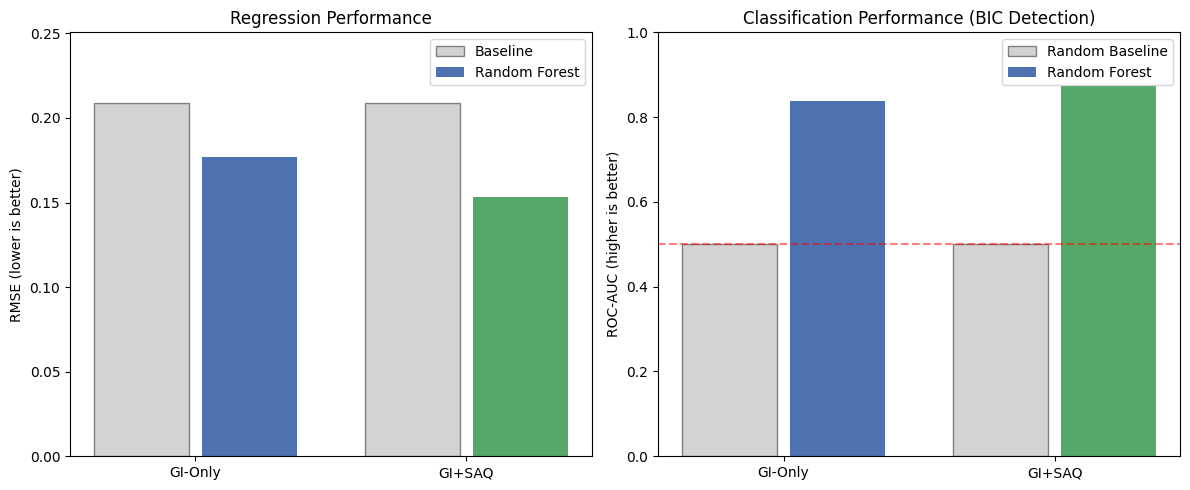

Saved: analysis_outputs/performance_comparison.png


In [37]:
# Cell 13: Visualize performance comparison

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: RMSE comparison
ax1 = axes[0]
rmse_data = regression_df[regression_df["model"] == "random_forest"]
x = np.arange(2)
bars1 = ax1.bar(x - 0.2, [baseline_results["gi_only"]["rmse"], baseline_results["gi_plus_saq"]["rmse"]], 
                0.35, label="Baseline", color="lightgray", edgecolor="gray")
bars2 = ax1.bar(x + 0.2, rmse_data["rmse"].values, 0.35, label="Random Forest", color=["#4c72b0", "#55a868"])
ax1.set_ylabel("RMSE (lower is better)")
ax1.set_title("Regression Performance")
ax1.set_xticks(x)
ax1.set_xticklabels(["GI-Only", "GI+SAQ"])
ax1.legend()
ax1.set_ylim(0, max(baseline_results["gi_only"]["rmse"], baseline_results["gi_plus_saq"]["rmse"]) * 1.2)

# Right: AUC comparison  
ax2 = axes[1]
auc_data = classification_df[(classification_df["model"] == "random_forest")]
bars3 = ax2.bar(x - 0.2, [0.5, 0.5], 0.35, label="Random Baseline", color="lightgray", edgecolor="gray")
bars4 = ax2.bar(x + 0.2, auc_data["roc_auc"].values, 0.35, label="Random Forest", color=["#4c72b0", "#55a868"])
ax2.set_ylabel("ROC-AUC (higher is better)")
ax2.set_title("Classification Performance (BIC Detection)")
ax2.set_xticks(x)
ax2.set_xticklabels(["GI-Only", "GI+SAQ"])
ax2.legend()
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color="red", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig("analysis_outputs/performance_comparison.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: analysis_outputs/performance_comparison.png")

## 10. Feature Importance Analysis (SHAP)

We use SHAP values to understand which features drive predictions for each model.

In [38]:
# Cell 14: Calculate SHAP values for both models

shap_results = {}

for feature_set in ["gi_only", "gi_plus_saq"]:
    rf_key = f"{feature_set}__regression__random_forest"
    pipeline = model_registry[rf_key]
    bundle = feature_bundles[feature_set]
    
    # Sample for SHAP (computation can be slow)
    X_sample = bundle["X_train"].sample(n=min(300, len(bundle["X_train"])), random_state=42)
    
    transformer = pipeline.named_steps["prep"]
    model = pipeline.named_steps["model"]
    
    transformed = transformer.transform(X_sample)
    feature_names = transformer.get_feature_names_out()
    
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(transformed)
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    
    # Create summary dataframe
    shap_df = pd.DataFrame({
        "feature": feature_names,
        "mean_abs_shap": mean_abs_shap,
    }).sort_values("mean_abs_shap", ascending=False).head(15)
    
    # Add topic interpretation
    shap_df["topic"] = shap_df["feature"].map(lambda x: COLUMN_TOPIC_LOOKUP.get(x, "-"))
    shap_df["chapter"] = shap_df["feature"].map(lambda x: COLUMN_CHAPTER_LOOKUP.get(x, "-"))
    
    shap_results[feature_set] = shap_df
    
print("SHAP analysis complete for both models!")

SHAP analysis complete for both models!


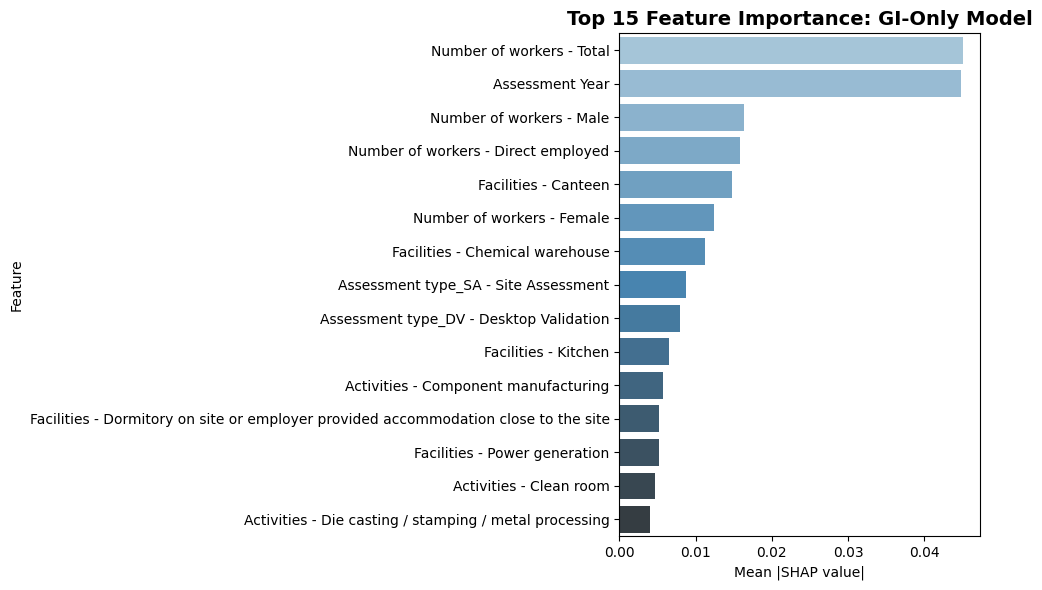


=== GI-Only Top Drivers ===


,feature,mean_abs_shap,topic
23,Number of workers - Total,0.045033,-
0,Assessment Year,0.044841,-
24,Number of workers - Male,0.016296,-
27,Number of workers - Direct employed,0.015855,-
18,Facilities - Canteen,0.014834,-
25,Number of workers - Female,0.012383,-
21,Facilities - Chemical warehouse,0.011286,-
63,Assessment type_SA - Site Assessment,0.008747,-
62,Assessment type_DV - Desktop Validation,0.008010,-
19,Facilities - Kitchen,0.006510,-



Saved: analysis_outputs/shap_gi_only.png


In [39]:
# Cell 15: Visualize SHAP importance - GI-Only Model

shap_gi = shap_results["gi_only"]

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=shap_gi,
    x="mean_abs_shap",
    y="feature",
    palette="Blues_d"
)
ax.set_title("Top 15 Feature Importance: GI-Only Model", fontsize=14, fontweight="bold")
ax.set_xlabel("Mean |SHAP value|")
ax.set_ylabel("Feature")

plt.tight_layout()
plt.savefig("analysis_outputs/shap_gi_only.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n=== GI-Only Top Drivers ===")
display(shap_gi[["feature", "mean_abs_shap", "topic"]].head(10))
print("\nSaved: analysis_outputs/shap_gi_only.png")

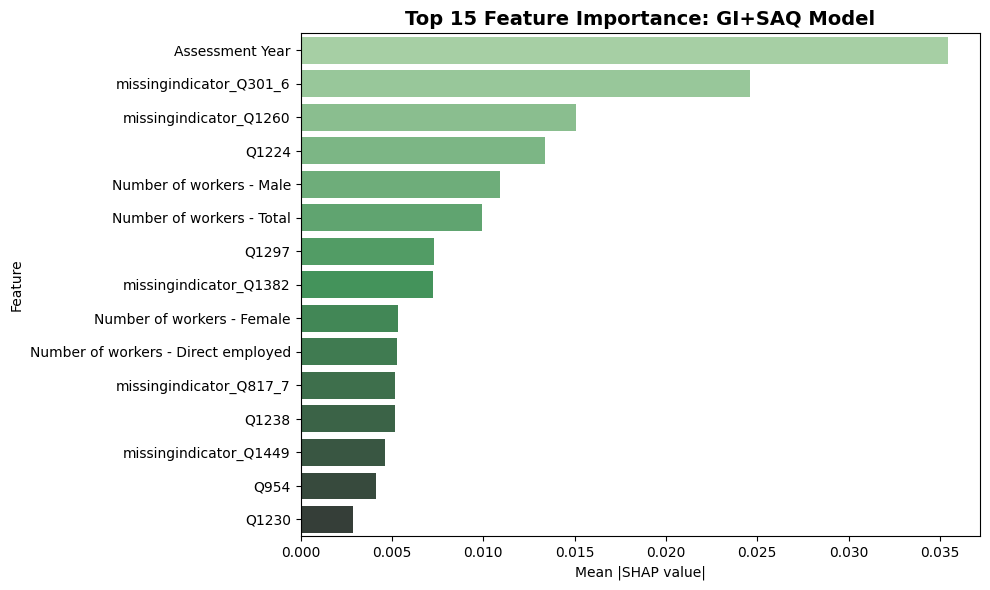


=== GI+SAQ Top Drivers ===


,feature,mean_abs_shap,topic,chapter
0,Assessment Year,0.035418,-,-
558,missingindicator_Q301_6,0.024618,-,-
588,missingindicator_Q1260,0.015076,-,-
62,Q1224,0.013379,Procedures,Environment
24,Number of workers - Male,0.010901,-,-
23,Number of workers - Total,0.009924,-,-
179,Q1297,0.007308,Implementation,Health and Safety
788,missingindicator_Q1382,0.007228,-,-
25,Number of workers - Female,0.005344,-,-
27,Number of workers - Direct employed,0.005260,-,-



Saved: analysis_outputs/shap_gi_plus_saq.png


In [40]:
# Cell 16: Visualize SHAP importance - GI+SAQ Model

shap_saq = shap_results["gi_plus_saq"]

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=shap_saq,
    x="mean_abs_shap",
    y="feature",
    palette="Greens_d"
)
ax.set_title("Top 15 Feature Importance: GI+SAQ Model", fontsize=14, fontweight="bold")
ax.set_xlabel("Mean |SHAP value|")
ax.set_ylabel("Feature")

plt.tight_layout()
plt.savefig("analysis_outputs/shap_gi_plus_saq.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n=== GI+SAQ Top Drivers ===")
display(shap_saq[["feature", "mean_abs_shap", "topic", "chapter"]].head(10))
print("\nSaved: analysis_outputs/shap_gi_plus_saq.png")

## 11. Risk Segmentation Framework

We create a 5-tier risk framework based on predicted sustainability scores to guide procurement decisions.

In [41]:
# Cell 17: Create risk segmentation

def assign_risk_tier(score):
    """Assign risk tier based on predicted Val_Score."""
    if score >= 0.80:
        return "Low Risk"
    elif score >= 0.70:
        return "Moderate Risk"
    elif score >= 0.60:
        return "Medium Risk"
    elif score >= 0.50:
        return "High Risk"
    else:
        return "Critical Risk"

# Get predictions from best model (GI+SAQ Random Forest)
best_pipeline = model_registry["gi_plus_saq__regression__random_forest"]
test_predictions = best_pipeline.predict(feature_bundles["gi_plus_saq"]["X_test"])

# Create risk assessment dataframe
risk_assessment = test_df[[ID_COLUMN, TARGET_COLUMN, "is_bic", "Country", "region_group"]].copy()
risk_assessment["predicted_val_score"] = test_predictions
risk_assessment["risk_tier"] = risk_assessment["predicted_val_score"].apply(assign_risk_tier)

print("=== Risk Tier Distribution ===")
tier_counts = risk_assessment["risk_tier"].value_counts()
display(tier_counts)

=== Risk Tier Distribution ===


risk_tier
Critical Risk    118
High Risk         77
Medium Risk       34
Moderate Risk     12
Name: count, dtype: int64

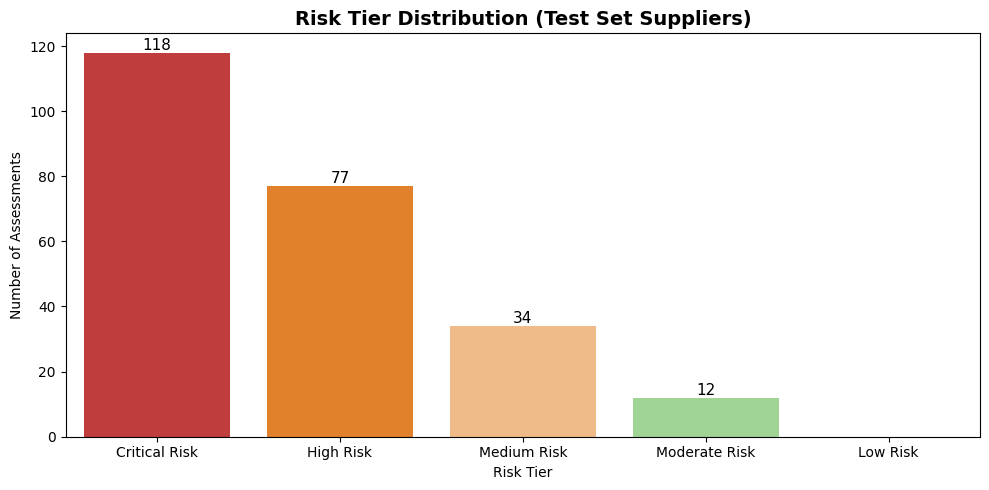


Saved: analysis_outputs/risk_segmentation.png

=== Recommended Actions by Tier ===
  Critical Risk (118): Immediate audit and corrective action plan
  High Risk (77): Targeted review, request documentation
  Medium Risk (34): Desktop review, monitor via SAQ updates
  Moderate Risk (12): Standard monitoring cadence
  Low Risk (0): Consider for BIC recognition and partnership


In [42]:
# Cell 18: Visualize risk segmentation

tier_order = ["Critical Risk", "High Risk", "Medium Risk", "Moderate Risk", "Low Risk"]
tier_colors = ["#d62728", "#ff7f0e", "#ffbb78", "#98df8a", "#2ca02c"]

plt.figure(figsize=(10, 5))
ax = sns.countplot(
    data=risk_assessment,
    x="risk_tier",
    order=tier_order,
    palette=tier_colors,
)
ax.set_title("Risk Tier Distribution (Test Set Suppliers)", fontsize=14, fontweight="bold")
ax.set_xlabel("Risk Tier")
ax.set_ylabel("Number of Assessments")

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig("analysis_outputs/risk_segmentation.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nSaved: analysis_outputs/risk_segmentation.png")
print("\n=== Recommended Actions by Tier ===")
actions = {
    "Critical Risk": "Immediate audit and corrective action plan",
    "High Risk": "Targeted review, request documentation",
    "Medium Risk": "Desktop review, monitor via SAQ updates",
    "Moderate Risk": "Standard monitoring cadence",
    "Low Risk": "Consider for BIC recognition and partnership"
}
for tier, action in actions.items():
    count = tier_counts.get(tier, 0)
    print(f"  {tier} ({count}): {action}")

## 12. Fairness Analysis

We check for geographic bias by comparing the False Negative Rate (FNR) across regions.
FNR = Rate at which actual BIC suppliers are incorrectly classified as non-BIC.

In [43]:
# Cell 19: Calculate False Negative Rate by region

def compute_fnr(y_true, y_pred):
    """Calculate False Negative Rate."""
    fn = np.logical_and(y_true == 1, y_pred == 0).sum()
    tp = np.logical_and(y_true == 1, y_pred == 1).sum()
    denom = tp + fn
    return fn / denom if denom > 0 else np.nan

# Get classification predictions
clf_pipeline = model_registry["gi_plus_saq__classification__random_forest"]
clf_predictions = clf_pipeline.predict(feature_bundles["gi_plus_saq"]["X_test"])
risk_assessment["clf_prediction"] = clf_predictions

# Calculate FNR by region
fnr_by_region = risk_assessment.groupby("region_group").apply(
    lambda df: compute_fnr(df["is_bic"].to_numpy(), df["clf_prediction"].to_numpy())
).rename("fnr")

print("=== False Negative Rate by Region ===")
for region, fnr in fnr_by_region.items():
    print(f"  {region}: {fnr:.1%}")
    
# Also show actual BIC counts by region
print("\n=== Actual BIC Suppliers in Test Set ===")
bic_by_region = risk_assessment.groupby("region_group")["is_bic"].sum()
display(bic_by_region)

=== False Negative Rate by Region ===
  China: 85.7%
  Rest of World: nan%

=== Actual BIC Suppliers in Test Set ===


region_group
China            21
Rest of World     0
Name: is_bic, dtype: int64

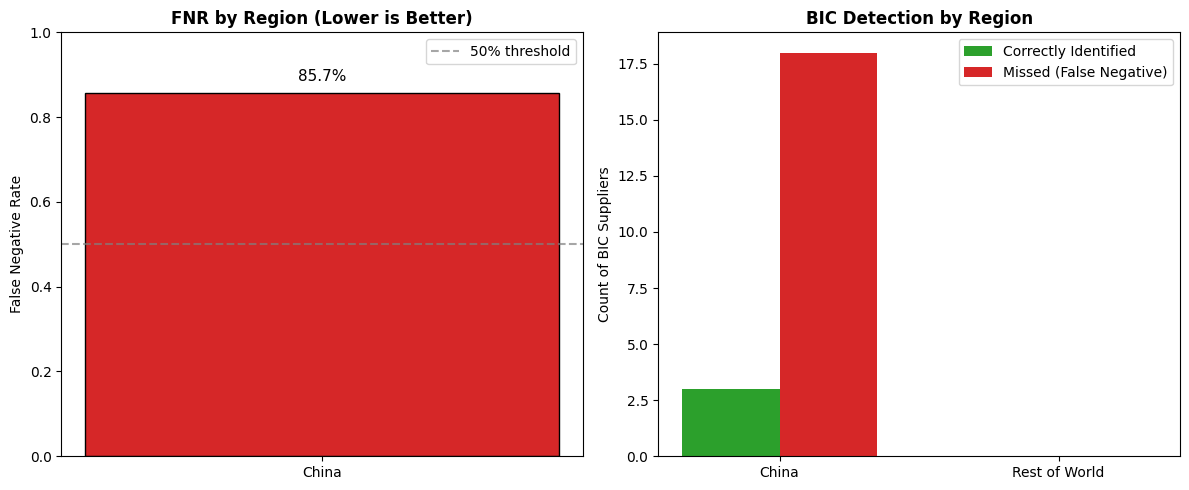


Saved: analysis_outputs/fairness_check.png


In [44]:
# Cell 20: Visualize fairness check

fnr_plot_data = fnr_by_region.reset_index()
fnr_plot_data.columns = ["Region", "False Negative Rate"]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: FNR comparison
ax1 = axes[0]
colors = ["#d62728" if fnr > 0.5 else "#2ca02c" for fnr in fnr_plot_data["False Negative Rate"]]
bars = ax1.bar(fnr_plot_data["Region"], fnr_plot_data["False Negative Rate"], color=colors, edgecolor="black")
ax1.set_ylim(0, 1)
ax1.set_ylabel("False Negative Rate")
ax1.set_title("FNR by Region (Lower is Better)", fontsize=12, fontweight="bold")
ax1.axhline(0.5, color="gray", linestyle="--", alpha=0.7, label="50% threshold")
ax1.legend()

# Add value labels
for bar, fnr in zip(bars, fnr_plot_data["False Negative Rate"]):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{fnr:.1%}', ha='center', va='bottom', fontsize=11)

# Right: BIC detection summary
ax2 = axes[1]
summary_data = risk_assessment.groupby("region_group").agg({
    "is_bic": "sum",
}).reset_index()
summary_data.columns = ["Region", "Actual BIC"]

# Calculate correctly identified BIC
correct_bic = risk_assessment.groupby("region_group").apply(
    lambda df: np.logical_and(df["is_bic"] == 1, df["clf_prediction"] == 1).sum()
).values
summary_data["Correctly Identified"] = correct_bic
summary_data["Missed (FN)"] = summary_data["Actual BIC"] - summary_data["Correctly Identified"]

x = np.arange(len(summary_data))
width = 0.35
bars1 = ax2.bar(x - width/2, summary_data["Correctly Identified"], width, label="Correctly Identified", color="#2ca02c")
bars2 = ax2.bar(x + width/2, summary_data["Missed (FN)"], width, label="Missed (False Negative)", color="#d62728")
ax2.set_xticks(x)
ax2.set_xticklabels(summary_data["Region"])
ax2.set_ylabel("Count of BIC Suppliers")
ax2.set_title("BIC Detection by Region", fontsize=12, fontweight="bold")
ax2.legend()

plt.tight_layout()
plt.savefig("analysis_outputs/fairness_check.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nSaved: analysis_outputs/fairness_check.png")

In [45]:
# Cell 21: Fairness analysis interpretation

china_fnr = fnr_by_region.get("China", 0)
row_fnr = fnr_by_region.get("Rest of World", 0)

print("="*60)
print("              FAIRNESS ANALYSIS SUMMARY")
print("="*60)

if china_fnr > 0.5:
    print(f"\n⚠️  WARNING: High False Negative Rate for China ({china_fnr:.1%})")
    print("   This means high-performing Chinese suppliers are frequently")
    print("   underestimated by the model.")
    print("\n   Possible causes:")
    print("   - Regional differences in reporting standards")
    print("   - Different assessment patterns for Chinese suppliers")
    print("   - Underrepresentation in training data")
    print("\n   Recommended mitigation:")
    print("   - Manual review for Chinese suppliers near BIC threshold (0.70-0.75)")
    print("   - Consider region-specific calibration")
else:
    print(f"\n✓ False Negative Rates are acceptable across regions")
    print(f"   China: {china_fnr:.1%}")
    print(f"   Rest of World: {row_fnr:.1%}")

              FAIRNESS ANALYSIS SUMMARY

⚠️  WARNING: High False Negative Rate for China (85.7%)
   This means high-performing Chinese suppliers are frequently
   underestimated by the model.

   Possible causes:
   - Regional differences in reporting standards
   - Different assessment patterns for Chinese suppliers
   - Underrepresentation in training data

   Recommended mitigation:
   - Manual review for Chinese suppliers near BIC threshold (0.70-0.75)
   - Consider region-specific calibration


## 13. Conclusions and Recommendations

In [46]:
# Cell 22: Generate summary metrics for brief

# Save metrics to JSON for brief
import json as json_lib

metrics = {
    "gi_only": {
        "rmse": float(rf_gi_reg["rmse"]),
        "r2": float(rf_gi_reg["r2"]),
        "auc": float(rf_gi_clf["roc_auc"]),
        "accuracy": float(rf_gi_clf["accuracy"]),
    },
    "gi_plus_saq": {
        "rmse": float(rf_saq_reg["rmse"]),
        "r2": float(rf_saq_reg["r2"]),
        "auc": float(rf_saq_clf["roc_auc"]),
        "accuracy": float(rf_saq_clf["accuracy"]),
    },
    "improvement": {
        "rmse_pct": float((rf_gi_reg["rmse"] - rf_saq_reg["rmse"]) / rf_gi_reg["rmse"] * 100),
        "r2_pct": float((rf_saq_reg["r2"] - rf_gi_reg["r2"]) / max(rf_gi_reg["r2"], 0.001) * 100),
        "auc_pts": float((rf_saq_clf["roc_auc"] - rf_gi_clf["roc_auc"]) * 100),
    },
    "fairness": {
        "fnr_china": float(fnr_by_region.get("China", 0)),
        "fnr_row": float(fnr_by_region.get("Rest of World", 0)),
    }
}

with open("analysis_outputs/metrics.json", "w") as f:
    json_lib.dump(metrics, f, indent=2)

print("Metrics saved to analysis_outputs/metrics.json")
print("\n" + "="*60)
print("              ANALYSIS COMPLETE")
print("="*60)
print("\nGenerated outputs:")
print("  - analysis_outputs/performance_comparison.png")
print("  - analysis_outputs/shap_gi_only.png")
print("  - analysis_outputs/shap_gi_plus_saq.png")
print("  - analysis_outputs/risk_segmentation.png")
print("  - analysis_outputs/fairness_check.png")
print("  - analysis_outputs/metrics.json")

Metrics saved to analysis_outputs/metrics.json

              ANALYSIS COMPLETE

Generated outputs:
  - analysis_outputs/performance_comparison.png
  - analysis_outputs/shap_gi_only.png
  - analysis_outputs/shap_gi_plus_saq.png
  - analysis_outputs/risk_segmentation.png
  - analysis_outputs/fairness_check.png
  - analysis_outputs/metrics.json
